# Homework Assignment 10

**Question 1:** Use PySpark and the [Wine Reviews dataset](https://www.kaggle.com/zynicide/wine-reviews) to:
- Explore  the datasets using Spark DataFrame by creating **3 different data visualizations, including map visualization** (30pt)
- Create a regression model that can predict the Wine Review's points value and evaluate the model(20pt)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=6ee9ab9595edea4cb9ac67b009f6d3e93e2e8d175fa2091b38debf6064c5e509
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark
 94% 48.0M/50.9M [00:03<00:00, 24.5MB/s]
100% 50.9M/50.9M [00:03<00:00, 16.6MB/s]
Archive:  wine-reviews.zip
  inflating: winemag-data-130k-v2.csv  
  inflating: winemag-data-130k-v2.json  
  inflating: winemag-data_first150k.csv  


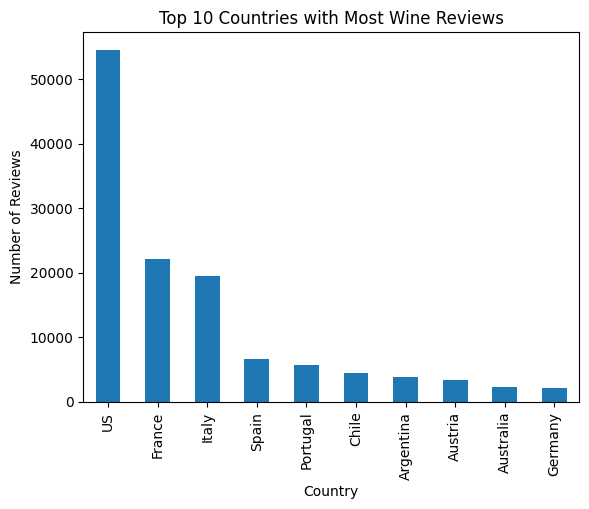

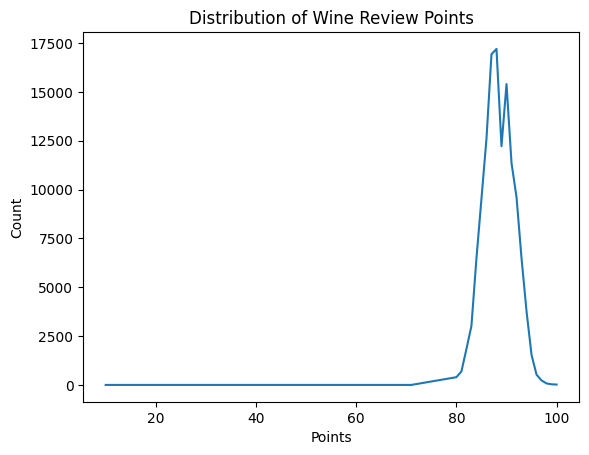



Root Mean Squared Error (RMSE): 2.740097657866789


In [1]:
!pip install pyspark

import json
import plotly.express as px
from matplotlib import pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

# Config kaggle
!mkdir /root/.kaggle/
api_token = {"username":"","key":""}
with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

# Download data
!kaggle datasets download -d zynicide/wine-reviews

# Unzip data
!unzip -o wine-reviews.zip

# Create a Spark session
spark = SparkSession.builder.appName("WineReviews").getOrCreate()

# Load the Wine Reviews dataset into a DataFrame
data = spark.read.format("csv").option("header", "true").load("winemag-data-130k-v2.csv")

# Convert "points" and "price" columns to numeric type
data = data.withColumn("points", col("points").cast("double"))
data = data.withColumn("price", col("price").cast("double"))

# 1.1. Explore the dataset using Spark DataFrame and create data visualizations

# Calculate the average of points by country
country_points = data.groupBy("country").avg("points").orderBy("avg(points)", ascending=False).toPandas()

# Plot the average of points by country as a choropleth
fig = px.choropleth(country_points, locations="country",
                    color="avg(points)",
                    hover_name="country",
                    hover_data=["avg(points)"],
                    locationmode="country names")
fig.update_layout(title_text=f"Average Wine Points by Country", title_x=0.5)
fig.show()
print("\n\n")

# Count the number of reviews by country
reviews_by_country = data.groupBy("country").count().orderBy("count", ascending=False).limit(10)

# Plot the reviews by country as a bar chart
reviews_by_country_pd = reviews_by_country.toPandas()
reviews_by_country_pd.plot(kind="bar", x="country", y="count", legend=None)
plt.xlabel("Country")
plt.ylabel("Number of Reviews")
plt.title("Top 10 Countries with Most Wine Reviews")
plt.show()
print(end="\n\n")

# Calculate the distribution of points
points_distribution = data.groupBy("points").count().orderBy("points")

# Plot the distribution of points as a line chart
points_distribution_pd = points_distribution.toPandas()
points_distribution_pd.plot(x="points", y="count", legend=None)
plt.xlabel("Points")
plt.ylabel("Count")
plt.title("Distribution of Wine Review Points")
plt.show()
print(end="\n\n")

# 1.2. Create a regression model to predict wine review points

# Select the relevant columns for the regression model
selected_data = data.select("points", "price", "country", "variety", "region_1")

# Drop rows with missing values
selected_data = selected_data.dropna()

# Convert categorical columns to numerical using StringIndexer
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(selected_data) for column in ["country", "variety", "region_1"]]
indexers_pipeline = Pipeline(stages=indexers)
indexed_data = indexers_pipeline.fit(selected_data).transform(selected_data)

# Assemble the features into a vector
assembler = VectorAssembler(inputCols=["price", "country_index", "variety_index", "region_1_index"], outputCol="features")
assembled_data = assembler.transform(indexed_data)

# Split the data into training and testing sets
(training_data, testing_data) = assembled_data.randomSplit([0.8, 0.2])

# Create a Linear Regression model
regression = LinearRegression(labelCol="points", featuresCol="features")

# Train the model
model = regression.fit(training_data)

# Make predictions on the testing data
predictions = model.transform(testing_data)

# Evaluate the model using RMSE metric
evaluator = RegressionEvaluator(labelCol="points", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

spark.stop()

**Question 2:** Use PySpark and the [Used Car Listings dataset](https://www.kaggle.com/jpayne/852k-used-car-listings) to:
- Explore  the datasets using Spamrk DataFrame by creating **3 different data visualizations, including  map visualization** (30pt)
- Create a regression model that can predict a car's listing price and evaluate the model (20pt)



100% 45.0M/45.2M [00:03<00:00, 24.9MB/s]
100% 45.2M/45.2M [00:03<00:00, 13.8MB/s]
Archive:  852k-used-car-listings.zip
  inflating: tc20171021.csv          
  inflating: true_car_listings.csv   


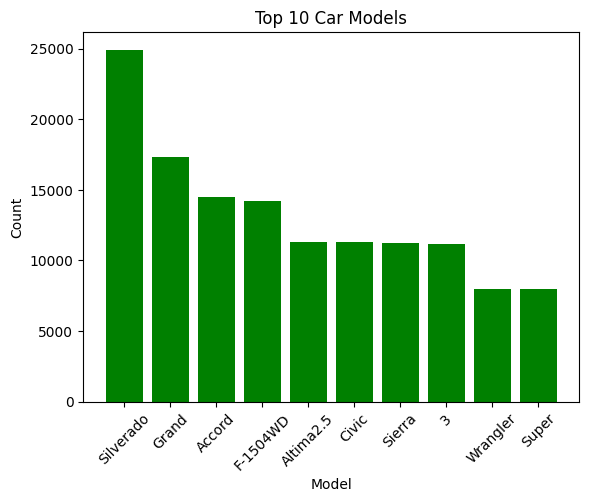

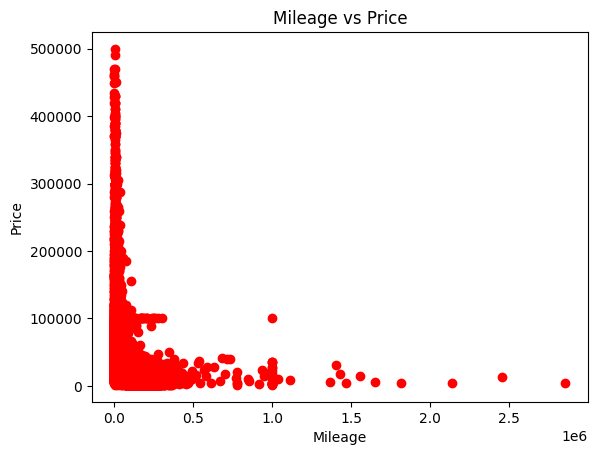




Root Mean Squared Error (RMSE): 12221.846318284996


In [2]:
# Download data
!kaggle datasets download -d jpayne/852k-used-car-listings

# Unzip data
!unzip -o 852k-used-car-listings.zip

# Create a SparkSession
spark = SparkSession.builder.appName("UsedCarListings").getOrCreate()

# Load the dataset
data = spark.read.csv("true_car_listings.csv", header=True, inferSchema=True)

# Explore the dataset using Spark DataFrame
# Visualization 1: choropleth of the Average Car Price by Country
state_prices = data.groupBy("state").avg("price").orderBy("avg(price)", ascending=False).toPandas()
state_prices['state'] = state_prices['state'].str.strip().str.upper()
fig = px.choropleth(state_prices, locations="state",
                    color="avg(price)",
                    hover_name="state",
                    hover_data=["avg(price)"],
                    locationmode="USA-states",
                    scope="usa")
fig.update_layout(title_text=f"Average Car Price by Country", title_x=0.5)
fig.show()
print("\n\n")

# Visualization 2: Bar chart of car brands
brand_counts = data.groupBy("Model").count().orderBy("count", ascending=False).limit(10).toPandas()
plt.bar(brand_counts["Model"], brand_counts["count"], color='green')
plt.xlabel("Model")
plt.ylabel("Count")
plt.title("Top 10 Car Models")
plt.xticks(rotation=45)
plt.show()
print("\n\n")

# Visualization 3: Scatter plot of mileage vs price
mileage_prices = data.select("Mileage", "Price").toPandas()
plt.scatter(mileage_prices["Mileage"], mileage_prices["Price"], color='red')
plt.xlabel("Mileage")
plt.ylabel("Price")
plt.title("Mileage vs Price")
plt.show()
print("\n\n")

# Create a regression model to predict car listing prices
assembler = VectorAssembler(inputCols=["Year", "Mileage"], outputCol="features")
data = assembler.transform(data)
train_data, test_data = data.randomSplit([0.8, 0.2])

lr = LinearRegression(labelCol="Price", featuresCol="features")
model = lr.fit(train_data)

# Evaluate the model
predictions = model.transform(test_data)
evaluator = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE):", rmse)

# Close the SparkSession
spark.stop()